In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

2024-07-03 04:24:17.130445: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 04:24:17.130557: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 04:24:17.256279: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Paths to your training and validation CSV files and image folders
train_csv = '/kaggle/input/gi-track/Training.csv'
train_image_folder = '/kaggle/input/gi-track/All_Images/Training'

val_csv = '/kaggle/input/gi-track/Validation.csv'
val_image_folder = '/kaggle/input/gi-track/All_Images/Validation'

test_csv = '/kaggle/input/gi-track/Testing.csv'
test_image_folder = '/kaggle/input/gi-track/All_Images/Testing'

# Load training and validation data from CSV files
train_data = pd.read_csv(train_csv)
train_data['class'] = train_data['class'].astype(str)

val_data = pd.read_csv(val_csv)
val_data['class'] = val_data['class'].astype(str)

# Load test data CSV
test_data = pd.read_csv(test_csv)
test_data['class'] = test_data['class'].astype(str)

# Create an ImageDataGenerator for training data
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_image_folder,
    x_col='filename',
    y_col='class',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'  # Ensure class_mode is 'binary' and 'y_col' values are strings
)

# Flow from dataframe for validation
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=val_image_folder,
    x_col='filename',
    y_col='class',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',  # Ensure class_mode is 'binary' and 'y_col' values are strings
    shuffle=False
)

# Flow from dataframe for test data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=test_image_folder,
    x_col='filename',
    y_col='class',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',  # Ensure class_mode is 'binary' and 'y_col' values are strings
    shuffle=False
)

Found 2412 validated image filenames belonging to 2 classes.
Found 244 validated image filenames belonging to 2 classes.
Found 521 validated image filenames belonging to 2 classes.


In [3]:
# Build the model (Using a pre-trained MobileNet model for transfer learning)
weight_path = '/kaggle/input/mobilenet/mobilenet_1_0_224_tf_no_top.h5'
base_model = tf.keras.applications.MobileNet(include_top=False, input_shape=(256, 256, 3), weights=weight_path)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [4]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    callbacks=[early_stop]
)

Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/76 ━━━━━━━━━━━━━━━━━━━━ 15:49 13s/step - accuracy: 0.4062 - loss: 0.9741

I0000 00:00:1719980706.574995     101 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


76/76 ━━━━━━━━━━━━━━━━━━━━ 48s 467ms/step - accuracy: 0.5687 - loss: 0.7570 - val_accuracy: 0.8730 - val_loss: 0.3581
Epoch 2/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.8199 - loss: 0.3778 - val_accuracy: 0.8648 - val_loss: 0.3063
Epoch 3/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.8851 - loss: 0.2933 - val_accuracy: 0.9057 - val_loss: 0.2666
Epoch 4/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9040 - loss: 0.2356 - val_accuracy: 0.9262 - val_loss: 0.2378
Epoch 5/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 0.9230 - loss: 0.1991 - val_accuracy: 0.9139 - val_loss: 0.2425
Epoch 6/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.9334 - loss: 0.1843 - val_accuracy: 0.9344 - val_loss: 0.2058
Epoch 7/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.9288 - loss: 0.1663 - val_accuracy: 0.9344 - val_loss: 0.2020
Epoch 8/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9297 - loss: 0.1719 - val_accuracy: 0.934

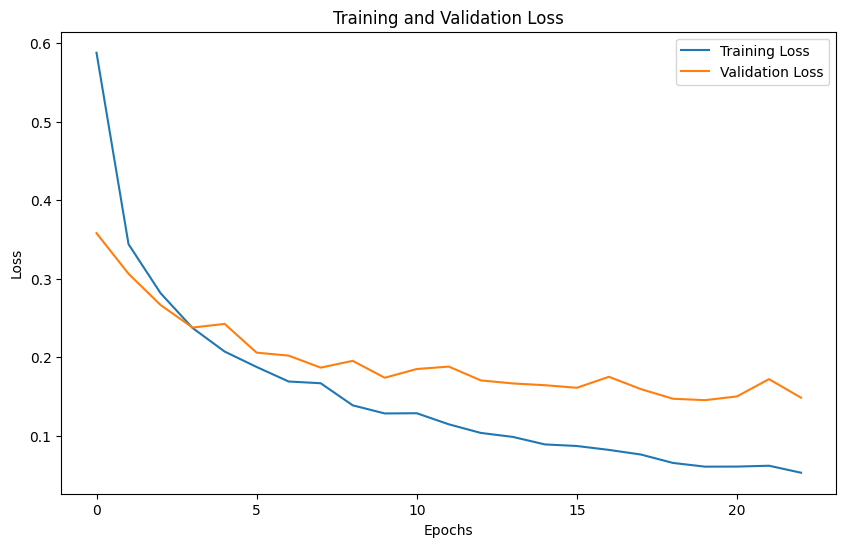

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
# Save the model
model.save('/kaggle/working/Mobilenet_model_Mix.h5')

In [7]:
# Evaluate the model
val_generator.reset()
predictions = model.predict(val_generator)
y_pred = (predictions > 0.5).astype(int)
y_true = val_generator.classes

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 342ms/step


Confusion Matrix
[[103   6]
 [  6 129]]
Classification Report
              precision    recall  f1-score   support

non-bleeding       0.94      0.94      0.94       109
    bleeding       0.96      0.96      0.96       135

    accuracy                           0.95       244
   macro avg       0.95      0.95      0.95       244
weighted avg       0.95      0.95      0.95       244


Class 0 - Non-Bleeding:
Sensitivity: 0.9450
Specificity: 0.9556
True Positive Rate: 0.9450
False Positive Rate: 0.0444

Class 1 - Bleeding:
Sensitivity: 0.9556
Specificity: 0.9450
True Positive Rate: 0.9556
False Positive Rate: 0.0550

ROC Curve Values:
FPR: [0.         0.         0.         0.00917431 0.00917431 0.03669725
 0.03669725 0.04587156 0.04587156 0.05504587 0.05504587 0.0733945
 0.0733945  0.10091743 0.10091743 0.21100917 0.21100917 0.2293578
 0.2293578  1.        ]
TPR: [0.         0.00740741 0.2962963  0.2962963  0.92592593 0.92592593
 0.93333333 0.93333333 0.94074074 0.94074074 0.95555556 

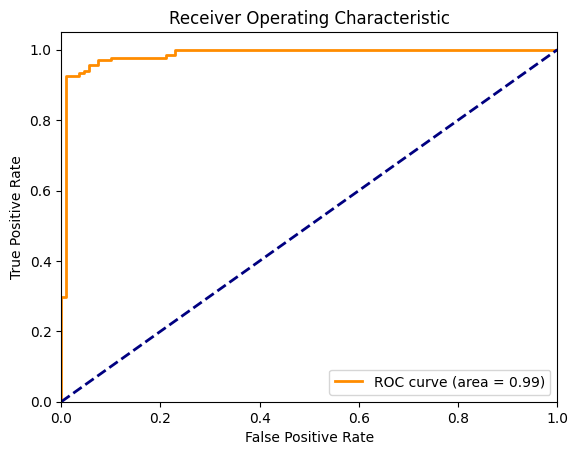

In [8]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix')
print(cm)

# Classification report
cr = classification_report(y_true, y_pred, target_names=['non-bleeding', 'bleeding'])
print('Classification Report')
print(cr)

# Sensitivity, Specificity, TPR, FPR for each class
tn, fp, fn, tp = cm.ravel()

# Class 0: Non-Bleeding
sensitivity_0 = tn / (tn + fp)
specificity_0 = tp / (tp + fn)
tpr_0 = sensitivity_0
fpr_0 = fn / (fn + tp)

# Class 1: Bleeding
sensitivity_1 = tp / (tp + fn)
specificity_1 = tn / (tn + fp)
tpr_1 = sensitivity_1
fpr_1 = fp / (fp + tn)

print(f"\nClass 0 - Non-Bleeding:")
print(f"Sensitivity: {sensitivity_0:.4f}")
print(f"Specificity: {specificity_0:.4f}")
print(f"True Positive Rate: {tpr_0:.4f}")
print(f"False Positive Rate: {fpr_0:.4f}")

print(f"\nClass 1 - Bleeding:")
print(f"Sensitivity: {sensitivity_1:.4f}")
print(f"Specificity: {specificity_1:.4f}")
print(f"True Positive Rate: {tpr_1:.4f}")
print(f"False Positive Rate: {fpr_1:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr, tpr)

# Store the ROC curve values for further use or plotting
roc_curve_values = {
    'fpr': fpr,
    'tpr': tpr,
    'thresholds': thresholds,
    'roc_auc': roc_auc
}

print(f"\nROC Curve Values:")
print(f"FPR: {roc_curve_values['fpr']}")
print(f"TPR: {roc_curve_values['tpr']}")
print(f"Thresholds: {roc_curve_values['thresholds']}")
print(f"ROC AUC: {roc_curve_values['roc_auc']:.2f}")

# Plotting the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [9]:
# Load the previously saved model
model = tf.keras.models.load_model('/kaggle/working/Mobilenet_model_Mix.h5')

# Evaluate the model on test data
test_generator.reset()
predictions = model.predict(test_generator)
y_pred = (predictions > 0.5).astype(int)
y_true = test_generator.classes

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 505ms/step


Confusion Matrix
[[303  17]
 [  5 196]]
Classification Report
              precision    recall  f1-score   support

non-bleeding       0.98      0.95      0.96       320
    bleeding       0.92      0.98      0.95       201

    accuracy                           0.96       521
   macro avg       0.95      0.96      0.96       521
weighted avg       0.96      0.96      0.96       521


Class 0 - Non-Bleeding:
Sensitivity: 0.9469
Specificity: 0.9751
True Positive Rate: 0.9469
False Positive Rate: 0.0249

Class 1 - Bleeding:
Sensitivity: 0.9751
Specificity: 0.9469
True Positive Rate: 0.9751
False Positive Rate: 0.0531

ROC Curve Values:
FPR: [0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.003125 0.003125 0.003125 0.003125 0.00625  0.00625  0.00625
 0.00625  0.009375 0.009375 0.0125   0.0125   0.015625 0.015625 0.01875
 0.01875  0.021875 0.021875 0.025    0.025    0.028125 0.028125 0.03125
 0.03125  0.034375 0.034375 0.046875 0.046875 0.05     0.05     0.05

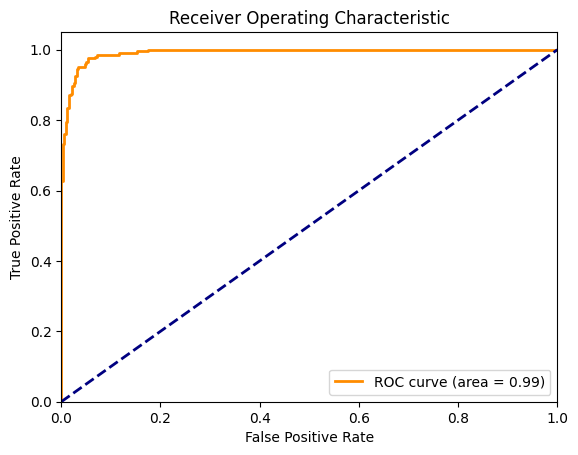

In [10]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix')
print(cm)

# Classification report
cr = classification_report(y_true, y_pred, target_names=['non-bleeding', 'bleeding'])
print('Classification Report')
print(cr)

# Calculate Sensitivity, Specificity, TPR, FPR for each class
tn, fp, fn, tp = cm.ravel()

# Class 0: Non-Bleeding
sensitivity_0 = tn / (tn + fp)
specificity_0 = tp / (tp + fn)
tpr_0 = sensitivity_0
fpr_0 = fn / (fn + tp)

# Class 1: Bleeding
sensitivity_1 = tp / (tp + fn)
specificity_1 = tn / (tn + fp)
tpr_1 = sensitivity_1
fpr_1 = fp / (fp + tn)

print(f"\nClass 0 - Non-Bleeding:")
print(f"Sensitivity: {sensitivity_0:.4f}")
print(f"Specificity: {specificity_0:.4f}")
print(f"True Positive Rate: {tpr_0:.4f}")
print(f"False Positive Rate: {fpr_0:.4f}")

print(f"\nClass 1 - Bleeding:")
print(f"Sensitivity: {sensitivity_1:.4f}")
print(f"Specificity: {specificity_1:.4f}")
print(f"True Positive Rate: {tpr_1:.4f}")
print(f"False Positive Rate: {fpr_1:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr, tpr)

# Store the ROC curve values for further use or plotting
roc_curve_values = {
    'fpr': fpr,
    'tpr': tpr,
    'thresholds': thresholds,
    'roc_auc': roc_auc
}

print(f"\nROC Curve Values:")
print(f"FPR: {roc_curve_values['fpr']}")
print(f"TPR: {roc_curve_values['tpr']}")
print(f"Thresholds: {roc_curve_values['thresholds']}")
print(f"ROC AUC: {roc_curve_values['roc_auc']:.2f}")

# Plotting the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()